In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from arc.Binary_Architecture import Model
import os
from data.Data_Interface import DataInterface
from model.Model_Interface import ModelInterface
from cf.DiPACE_FA import DiPACE_FA
from cf.DiPACE_Plus import DiPACE_Plus
from eval.Evaluation import Evaluate
pd.set_option('display.max_columns', None)

/Users/jacobsanderson/Documents/DiPACE/.venv/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
df = pd.read_csv('datasets/credit.csv')
df = df.drop(columns='ZipCode')

In [3]:
encoder = LabelEncoder()
df['Industry'] = encoder.fit_transform(df['Industry'])
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)
df['Ethnicity'] = encoder.fit_transform(df['Ethnicity'])
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)
df['Citizen'] = encoder.fit_transform(df['Citizen'])
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)

{'CommunicationServices': 0, 'ConsumerDiscretionary': 1, 'ConsumerStaples': 2, 'Education': 3, 'Energy': 4, 'Financials': 5, 'Healthcare': 6, 'Industrials': 7, 'InformationTechnology': 8, 'Materials': 9, 'Real Estate': 10, 'Research': 11, 'Transport': 12, 'Utilities': 13}
{'Asian': 0, 'Black': 1, 'Latino': 2, 'Other': 3, 'White': 4}
{'ByBirth': 0, 'ByOtherMeans': 1, 'Temporary': 2}


In [4]:
X = df.drop(columns=['Approved'])
y = df['Approved']

In [5]:
X = pd.get_dummies(X, columns=['Gender', 'Married', 'BankCustomer', 'Industry', 'Ethnicity', 'PriorDefault', 'CreditScore', 'Employed', 'DriversLicense', 'Citizen'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [8]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [9]:
input_size = X_train.shape[1]
model = Model(input_size)

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

Epoch [10/100], Loss: 0.6386187076568604
Epoch [20/100], Loss: 0.5622515082359314
Epoch [30/100], Loss: 0.46870630979537964
Epoch [40/100], Loss: 0.3779570162296295
Epoch [50/100], Loss: 0.30530062317848206
Epoch [60/100], Loss: 0.2564612329006195
Epoch [70/100], Loss: 0.22480881214141846
Epoch [80/100], Loss: 0.20174762606620789
Epoch [90/100], Loss: 0.18266257643699646
Epoch [100/100], Loss: 0.1656436026096344


In [12]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test.shape[0]
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8260869565217391


In [13]:
model_path = 'pytorch_model.pth'
torch.save(model.state_dict(), model_path)

In [14]:
d = DataInterface(dataframe=df, target='Approved', continuous_features=['Age', 'Debt', 'YearsEmployed', 'Income'])
m = ModelInterface(model_path='../DiPACE/pytorch_model.pth', input_size = input_size)

In [63]:
df = df[df['Approved']==0]
query_index = np.random.choice(len(df))
query_instance = df.iloc[96].drop('Approved').to_list()
print(query_index)

47


Desired class: tensor([1.], grad_fn=<RsubBackward1>)
Original class tensor([0.], grad_fn=<RoundBackward0>)
All CFs are classified as the desired class.
Final Loss: tensor(1.6222, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(5.8746e-05, grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(0.2996, grad_fn=<MeanBackward0>)
Final Diversity Loss: tensor(0.9488, grad_fn=<LinalgDetBackward0>)
Final Sparsity Loss: tensor(0.3508)
Final Plausibility Loss: tensor(3.4190, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are classified as the desired class.
Final Loss: tensor(1.3655, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(0.0376, grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(0.2861, grad_fn=<MeanBackward0>)
Final Diversity Loss: tensor(0.9539, grad_fn=<LinalgDetBackward0>)
Final Sparsity Loss: tensor(0.2984)
Final Plausibility Loss: tensor(3.0148, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are class

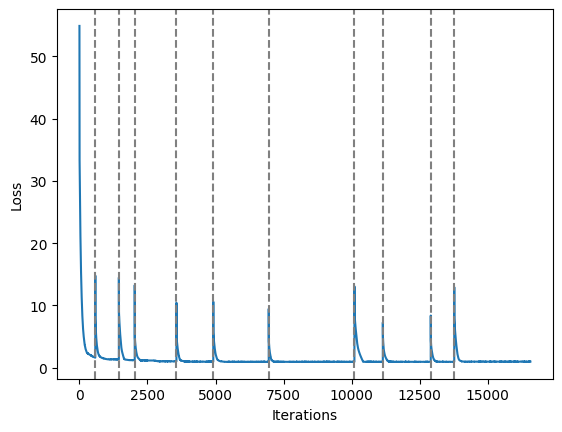

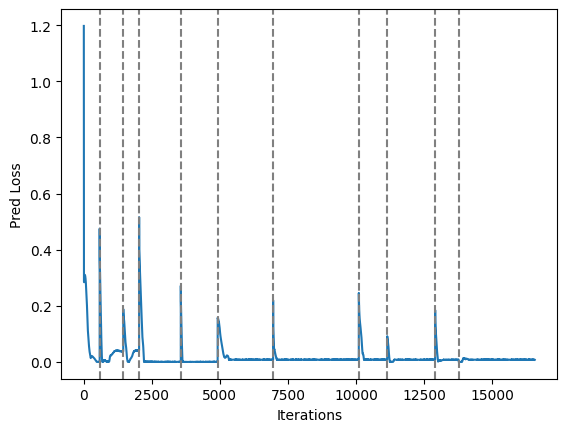

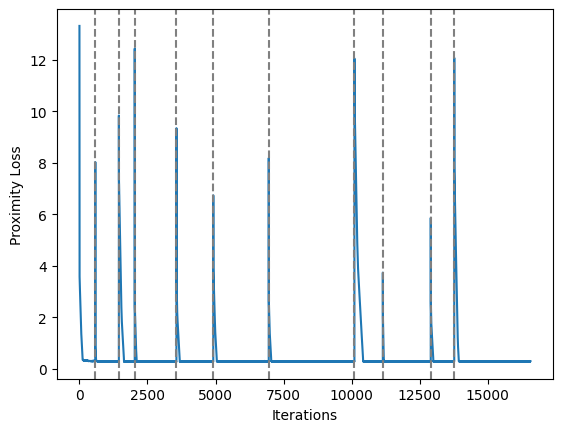

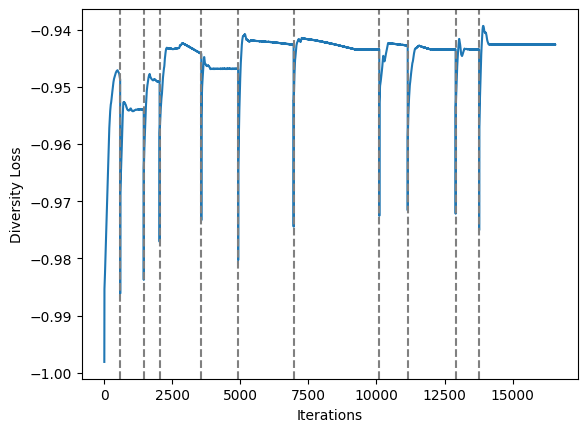

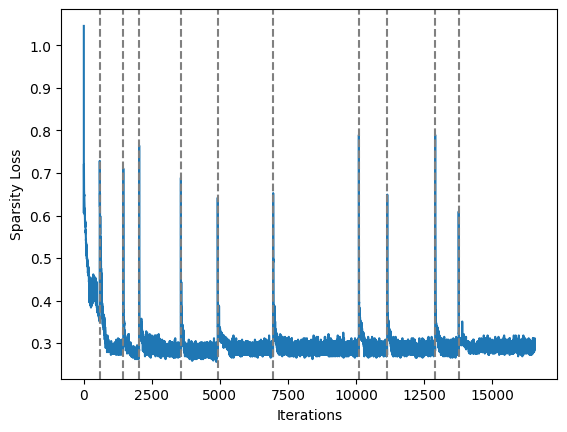

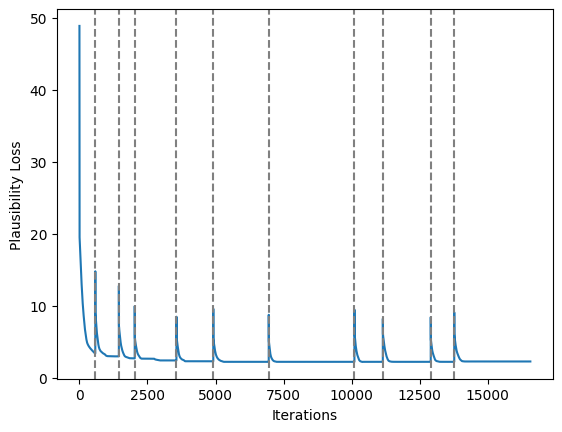

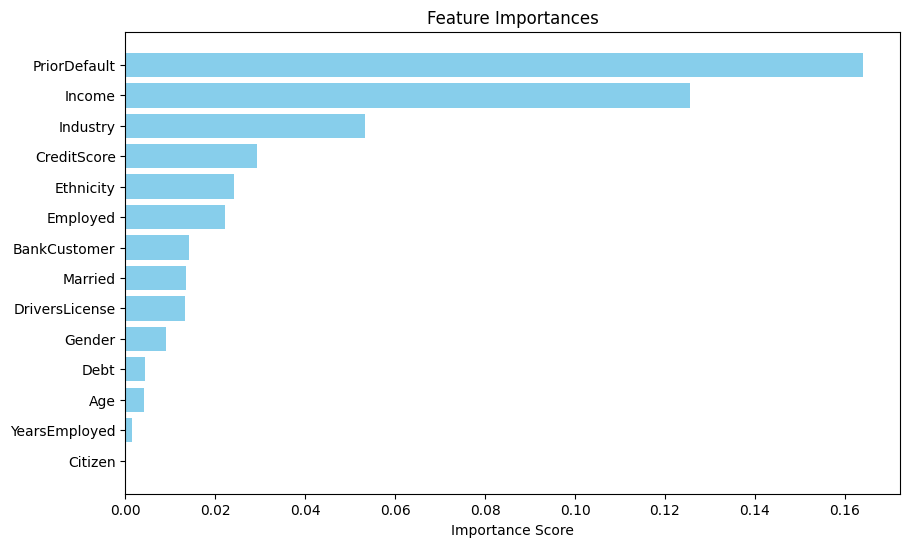

In [64]:
exp = DiPACE_FA(d, m)
cf = exp.generate_counterfactuals(query_instance, total_CFs=5, high_loss_threshold=0.7, immutable_features=['Citizen'])

In [65]:
query_instance, cf_instances = cf
query_instance = torch.Tensor(query_instance).float()
cf_instances = torch.Tensor(cf_instances).float()

In [66]:
eval = Evaluate(d, m)
print(eval.evaluate_confidence(cf_instances, desired_class=1))

tensor(0.7649, grad_fn=<MeanBackward0>)


In [67]:
query_instance = pd.DataFrame(query_instance, columns=X.columns)
cf_instances = pd.DataFrame(cf_instances, columns=X.columns)
query_instance = query_instance.drop(query_instance.filter(regex='^Citizen_').columns, axis=1)
cf_instances = cf_instances.drop(cf_instances.filter(regex='^Citizen_').columns, axis=1)
observed_instances = d.norm_encoded_features
observed_instances = observed_instances.drop(observed_instances.filter(regex='^Citizen_').columns, axis=1)
query_instance = torch.Tensor(np.array(query_instance)).float()
cf_instances = torch.Tensor(np.array(cf_instances)).float()

In [68]:

print(eval.evaluate_proximity(query_instance, cf_instances))
print(eval.evaluate_sparsity(query_instance, cf_instances))
print(eval.evaluate_diversity(cf_instances))
print(eval.evaluate_plausibility(cf_instances, observed_instances, k=1))
#eval.evaluate(query_instance, cf_instances, d.norm_encoded_features, desired_class=1, k=1)

tensor(0.2440)
tensor(0.2793)
tensor(0.9434)
tensor(0.5815)
